In [1]:
import numpy as np
import scipy.fftpack as fftpack
import pylab as plt
import matplotlib as matplotlib

import pycuda.gpuarray as gpuarray

#-------------------------------------------------------------------------------------
from pywignercuda_path import SetPyWignerCUDA_Path
SetPyWignerCUDA_Path()
from GPU_WignerDiracKvN2D_4x4 import *

In [2]:
%matplotlib inline

In [3]:
class Klein(GPU_WignerDiracKvN2D_4x4):
    def __init__ (self):
    #....................Defining the geometry..................................... 
        X_gridDIM = 512
        P_gridDIM = 512
        
        X_amplitude = 20  
        P_amplitude = 15   

        
        timeSteps  =  1000
        dt = 0.01 #dX/c
        
        skipFrames =   10

        #...................Defining the kinematic-dynamical constants.................
        
        mass = 1.
        c = 1.
        
        #self.dt = dX/self.c
        #...................Defining the potential and initial state parameters........
        V0 = 0.
        w  = 0.
        
        #.........................ODM damping ........................................
        self.gammaDamping = 0.0
        
        #............................................................................
        
        self.D_Theta      = 0.0
        self.D_Lambda     = 0.0
                
        #self.pX = 9.5
        self.Potential_0_String = ' 0.*x'
        self.Potential_1_String = ' 0.*x'
        self.Potential_2_String = ' 0.*x'
        self.Potential_3_String = ' 0.*x'

        
        #.............................................................................
        GPU_WignerDiracKvN2D_4x4.__init__(self,
            X_gridDIM, P_gridDIM, X_amplitude, P_amplitude, mass, c, dt,
            timeSteps,skipFrames,frameSaveMode='Density',antiParticleNorm = True, computeEnergy=True)
        #.............................................................................
        
          
    def  Set_Initial_State  (self) :
 
        #..................Defining the output directory/file ........................

        self.fileName = '/home/rcabrera/DATA/DiracKvN2D_4x4/Free.hdf5'
        
        self.W_init = np.empty([4,4,instance.P_gridDIM,instance.X_gridDIM],dtype = np.complex128)
        
        init_x  = -5
        self.pX = 2.
        s = 1.
        
        print ' v init = ', self.c * self.pX/np.sqrt( (self.mass*self.c)**2 + self.pX**2  )  #/ np.sqrt(   (self.mass*self,c)**2  + (self.pX)**2 )
        #
        
        psiL1 = self.GaussianSpinor_ParticleUp(  init_x , self.pX , s, self.X - 0.5*self.Theta )       
         
        psiR1 = self.GaussianSpinor_ParticleUp(  init_x , self.pX , s, self.X + 0.5*self.Theta )         

        #
        
        for i in range(4):
            for j in range(4):
                self.W_init[i,j][:,:] = psiL1[i]*psiR1[j].conj()
        
        # To XP       
        self.Fourier_4X4_Theta_To_P(self.W_init)
        
        instance.FilterElectrons( self.W_init , 1)
        
        norm = self.Wigner_4x4_Norm(self.W_init)
        self.W_init *= 1./ norm
        

In [4]:
instance = Klein()

  D_1_Potential_0 =  0 + 0.*x


In [5]:
(instance.mass)

1.0

In [6]:
instance.Set_Initial_State()

 v init =  0.894427191


In [7]:

#instance.Set_Initial_State()

instance.Run ()

----------------------------------------------
 Relativistic Wigner-Dirac Propagator:  x-Px  
----------------------------------------------
 dt      =  0.01
 dx      =  0.078125
 dp      =  0.05859375
 dLambda =  0.157079632679
            
         GPU memory Total        5.24945068359 GB
         GPU memory Free         4.89400863647 GB
 progress  0 %
 cuda grid =   ( (512, 1, 1)  ,  (512, 1, 1) )
 progress  0 %
 progress  1 %
 progress  2 %
 progress  3 %
 progress  4 %
 progress  5 %
 progress  6 %
 progress  7 %
 progress  8 %
 progress  9 %
 progress  10 %
 progress  11 %
 progress  12 %
 progress  13 %
 progress  14 %
 progress  15 %
 progress  16 %
 progress  17 %
 progress  18 %
 progress  19 %
 progress  20 %
 progress  21 %
 progress  22 %
 progress  23 %
 progress  24 %
 progress  25 %
 progress  26 %
 progress  27 %
 progress  28 %
 progress  29 %
 progress  30 %
 progress  31 %
 progress  32 %
 progress  33 %
 progress  34 %
 progress  35 %
 progress  36 %
 progress  37 

In [8]:
def PlotWigner(W):
    
    W0 = fftpack.fftshift(instance.Wigner_4X4__SpinTrace( W ).real)
    
    x_min = -instance.X_amplitude
    x_max = instance.X_amplitude - instance.dX
    
    p_min = -instance.P_amplitude
    p_max = instance.P_amplitude - instance.dP
    
    global_max = 0.31          #  Maximum value used to select the color range
    global_min = -0.27        # 

    print 'min = ', np.min( W0 ), ' max = ', np.max( W0 )
    print 'normalization = ', np.sum( W0 )*instance.dX*instance.dP

    zero_position =  abs( global_min) / (abs( global_max) + abs(global_min)) 
    wigner_cdict = {'red' 	: 	((0., 0., 0.),
							(zero_position, 1., 1.), 
							(1., 1., 1.)),
					'green' :	((0., 0., 0.),
							(zero_position, 1., 1.),
							(1., 0., 0.)),
					'blue'	:	((0., 1., 1.),
							(zero_position, 1., 1.),
							(1., 0., 0.)) }
    wigner_cmap = matplotlib.colors.LinearSegmentedColormap('wigner_colormap', wigner_cdict, 256)
    #wigner_cmap = plt.colors.LinearSegmentedColormap('wigner_colormap', wigner_cdict, 256)
    

    fig, ax = plt.subplots(figsize=(20, 7))

    
        
    cax = ax.imshow( W0 ,origin='lower',interpolation='nearest',\
    extent=[x_min, x_max, p_min, p_max], vmin= global_min, vmax=global_max, cmap=wigner_cmap)

    ax.set_xlabel('x')
    ax.set_ylabel('p')
    #ax.set_xlim((x_min,x_max))
    #ax.set_ylim((-5 , p_max/3.5))
    #ax.set_ylim((-16,16))    
    ax.set_aspect(1)
    ax.grid('on')

In [9]:
def PlotMarginal_P(instance):
    
    W_0 = fftpack.fftshift( instance.Wigner_4X4__SpinTrace(instance.W_init).real )
        
    print ' norm =  ', np.sum(W_0).real*instance.dX*instance.dP
    
    fig, ax = plt.subplots(figsize=(10, 5))

    prob_P = np.sum(W_0,axis=1)*instance.dX
    ax.plot(instance.P_range, prob_P , label = 'init')
    
    W_0 = fftpack.fftshift(  instance.Wigner_4X4__SpinTrace(instance.W_end).real )
    
    print ' norm =  ', np.sum(W_0).real*instance.dX*instance.dP
    
    prob_P = np.sum(W_0,axis=1)*instance.dX
    ax.plot(instance.P_range, prob_P , label = 'final')
    
    ax.set_xlim(-18,18)
    ax.set_xlabel('p')
    ax.set_ylabel('Prob')
    ax.grid('on')
    
    ax.legend(bbox_to_anchor=(0.75, 0.5), loc=2, prop={'size':22})
    
def PlotMarginal_X(instance):
    
    W_0 = fftpack.fftshift( instance.Wigner_4X4__SpinTrace(instance.W_init).real )
        
    
    fig, ax = plt.subplots(figsize=(10, 5))

    prob_X = np.sum(W_0,axis=0)*instance.dP
    ax.plot(instance.X_range, prob_X , label = 'init')
    
    W_0 = fftpack.fftshift( instance.Wigner_4X4__SpinTrace(instance.W_end).real )
    
    
    prob_X = np.sum(W_0,axis=0)*instance.dP
    ax.plot(instance.X_range, prob_X , label = 'final')
    
    ax.set_xlabel('x')
    ax.set_ylabel('Prob')
    ax.grid('on')
    
    ax.legend(bbox_to_anchor=(0.75, 0.5), loc=2, prop={'size':22})

min =  -0.00210914234406  max =  3.13367517599
normalization =  10.0


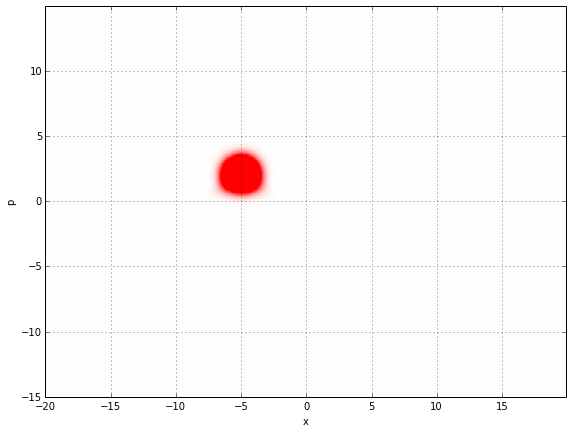

In [10]:
PlotWigner(10*instance.W_init)

min =  -0.00176907805108  max =  3.12208239049
normalization =  10.0
 time =  10.0


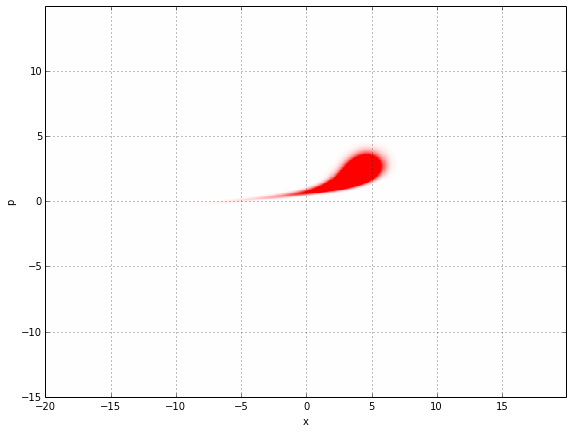

In [11]:
PlotWigner( 10*instance.W_end )
print ' time = ', instance.timeRange[-1]

 norm =   1.0
 norm =   1.0


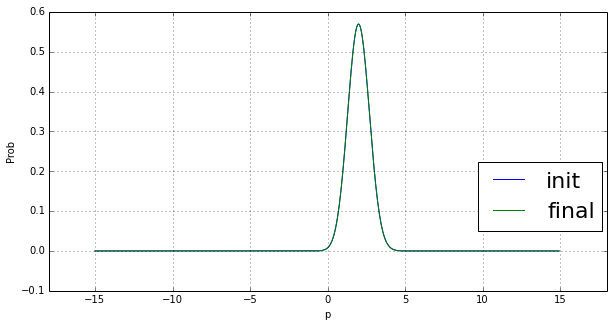

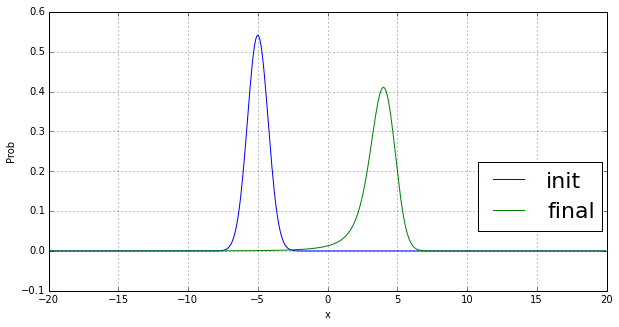

In [12]:
PlotMarginal_P( instance )
PlotMarginal_X( instance )

In [13]:
WendFilter = instance.W_end.copy()
instance.FilterElectrons( WendFilter , 1)

min =  -0.00404752004285  max =  3.05891781902
normalization =  9.99999999999


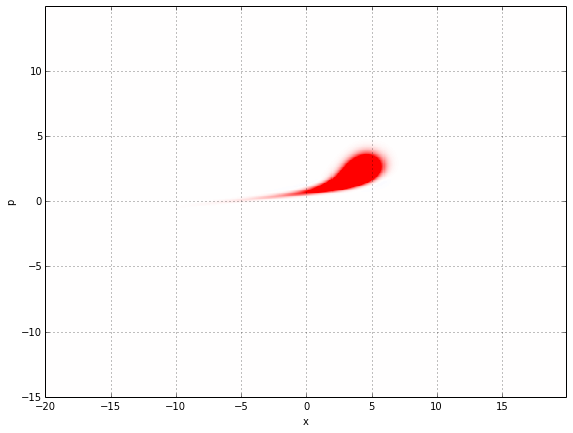

In [14]:
PlotWigner( 10*WendFilter )

## Ehrenfest Theorems

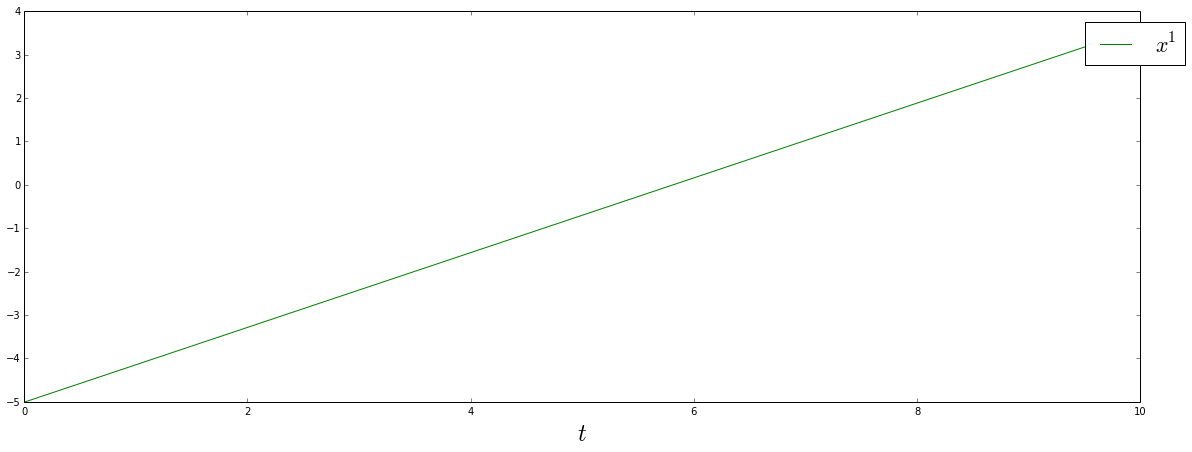

In [15]:
axis_font = {'size':'24'}


fig, ax = plt.subplots(figsize=(20, 7))
ax.plot( instance.timeRange[1:] ,   instance.X_Average.real  , 'g',
        label= '$ x^1 $')


ax.set_xlabel(r'$t$',**axis_font)

ax.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':22})

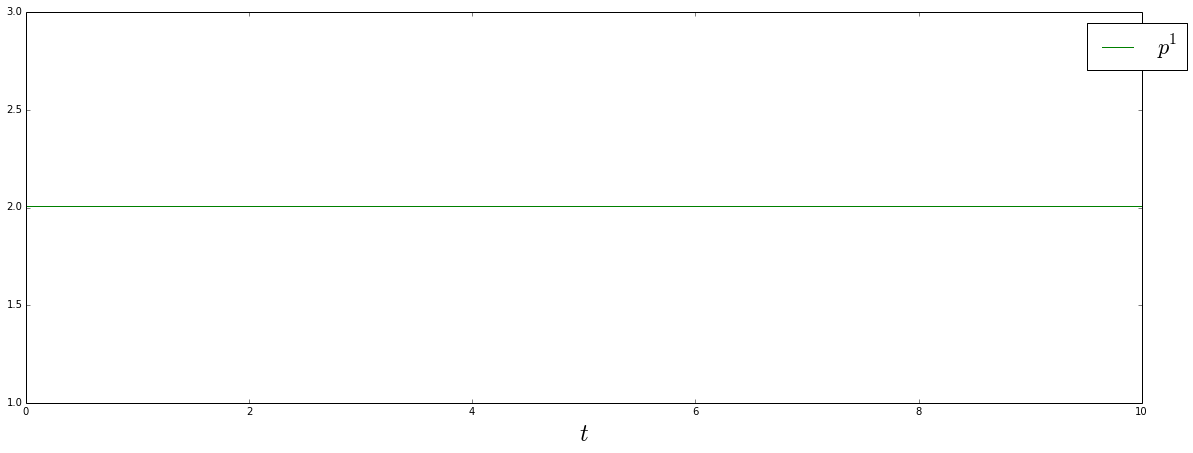

In [26]:
axis_font = {'size':'24'}

fig, ax = plt.subplots(figsize=(20, 7))
ax.plot( instance.timeRange[1:] ,   instance.P_Average.real  , 'g',
        label= '$ p^1 $')

ax.set_ylim(1, 3)

ax.set_xlabel(r'$t$',**axis_font)

ax.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':22})

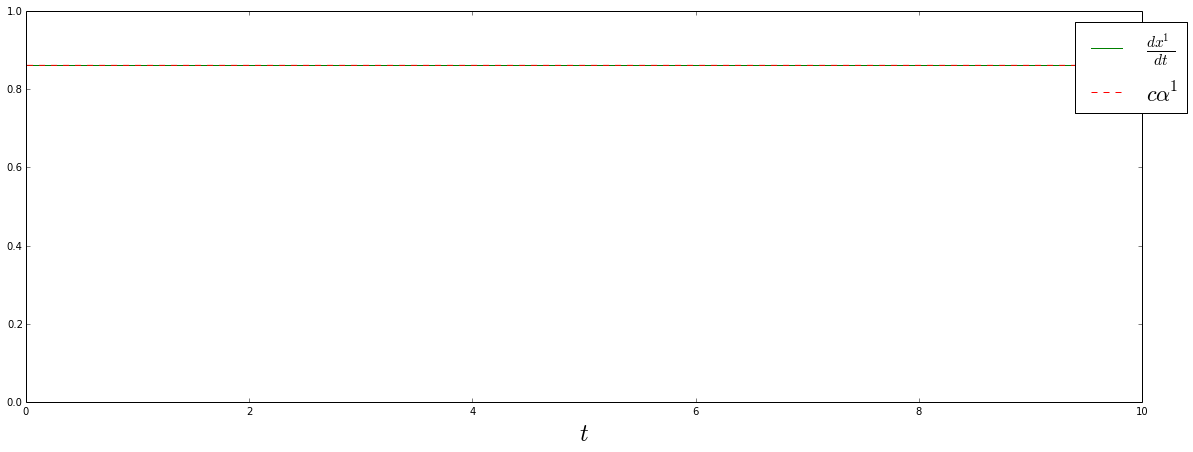

In [17]:
axis_font = {'size':'24'}


fig, ax = plt.subplots(figsize=(20, 7))
ax.plot( instance.timeRange[1:] ,  np.gradient( instance.X_Average.real , instance.dt)  , 'g',
        label= '$\\frac{dx^1}{dt} $')

ax.plot( instance.timeRange[1:] ,  instance.Alpha_1_Average.real ,'r--' ,label='$c \\alpha^1$')

ax.set_ylim(0, 1)

ax.set_xlabel(r'$t$',**axis_font)

ax.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':22})

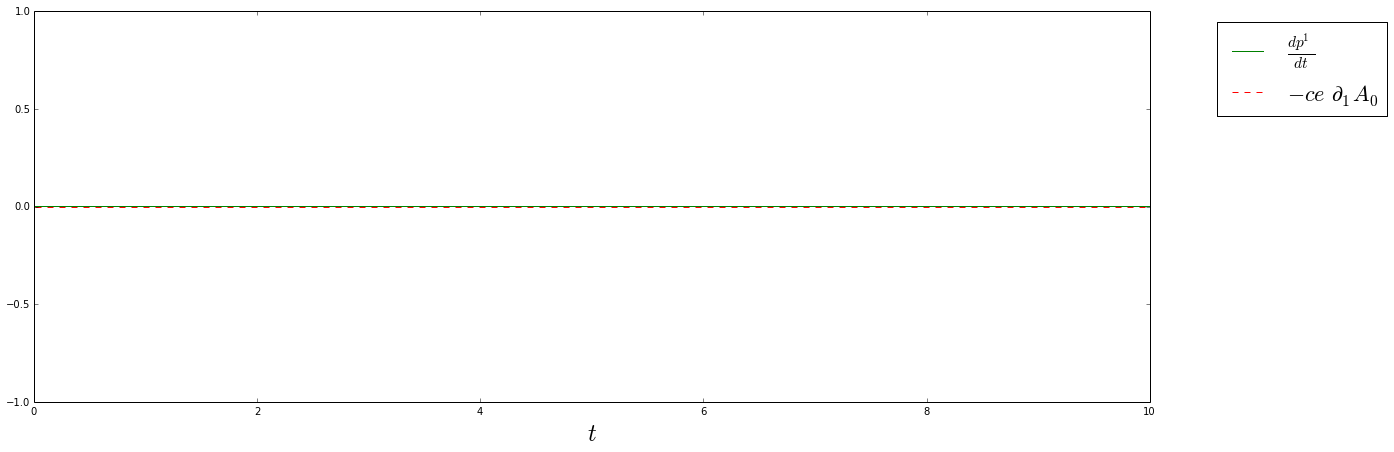

In [18]:
axis_font = {'size':'24'}


fig, ax = plt.subplots(figsize=(20, 7))
ax.plot( instance.timeRange[1:] ,  np.gradient( instance.P_Average.real , instance.dt)  , 'g',
        label= '$\\frac{dp^1}{dt} $')

ax.plot( instance.timeRange[1:] , 
        -instance.D_1_Potential_0_Average.real - 2.*instance.mass*instance.gammaDamping*instance.Alpha_1_Average.real ,'r--' ,label='$-c e\, \\partial_1 A_0  $')


ax.set_ylim(-1, 1)


ax.set_xlabel(r'$t$',**axis_font)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})

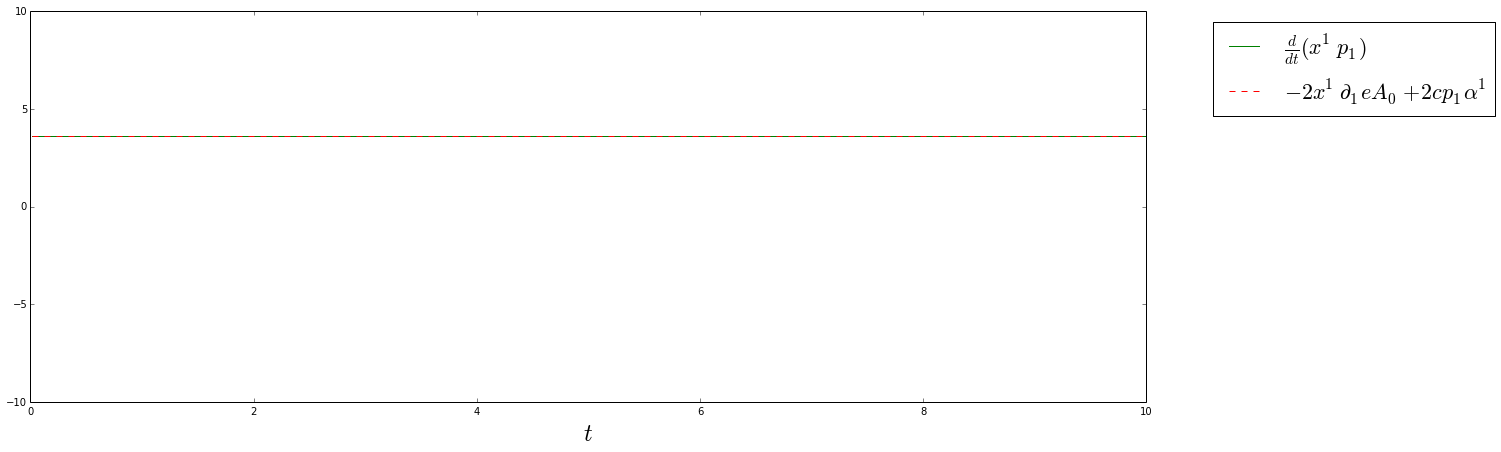

In [19]:
axis_font = {'size':'24'}

fig, ax = plt.subplots(figsize=(20, 7))
ax.plot( instance.timeRange[1:] ,
        2*np.gradient( instance.XP_Average.real , instance.dt)  , 'g',
        label= '$\\frac{d}{dt}( x^1 p_1 ) $')

ax.plot( instance.timeRange[1:] ,
        -2*instance.X1_D_1_Potential_0_Average.real + 2*instance.c*instance.P1_Alpha_1_Average.real -4.*instance.mass*instance.gammaDamping*instance.X1_Alpha_1_Average,
        'r--' ,label='$-2 x^1 \\partial_1 e A_0  + 2 c p_1 \\alpha^1$')

ax.set_ylim(-10, 10)

ax.set_xlabel(r'$t$',**axis_font)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})

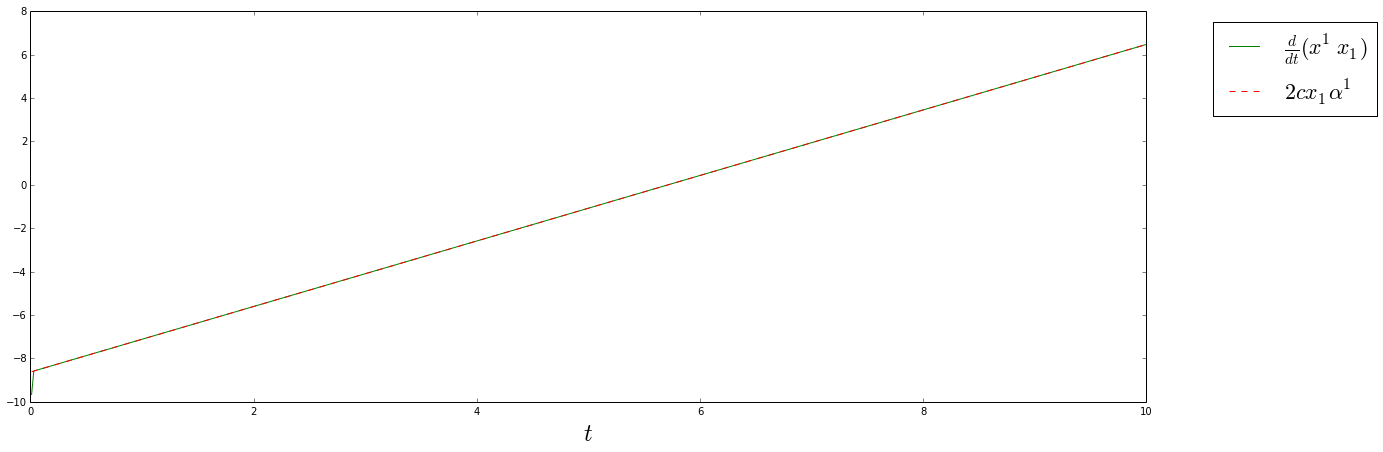

In [20]:
axis_font = {'size':'24'}

fig, ax = plt.subplots(figsize=(20, 7))
ax.plot( instance.timeRange[1:] ,
        np.gradient( instance.XX_Average.real , instance.dt)  , 'g',
        label= '$\\frac{d}{dt}( x^1 x_1 ) $')

ax.plot( instance.timeRange[1:] ,
      2*instance.c*instance.X1_Alpha_1_Average.real,
        'r--' ,label='$2 c x_1 \\alpha^1$')


ax.set_xlabel(r'$t$',**axis_font)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})

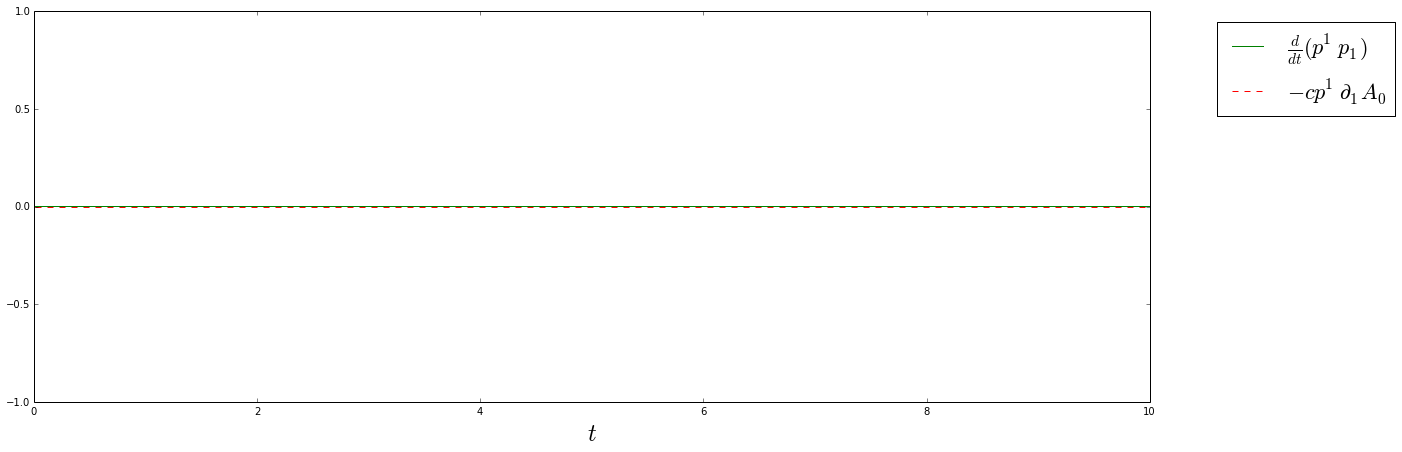

In [21]:
axis_font = {'size':'24'}

fig, ax = plt.subplots(figsize=(20, 7))
ax.plot( instance.timeRange[1:] ,
        np.gradient( instance.PP_Average.real , instance.dt)  , 'g',
        label= '$\\frac{d}{dt}( p^1 p_1 ) $')

ax.plot( instance.timeRange[1:] ,
       -2*instance.P1_D_1_Potential_0_Average.real - \
       4.*instance.mass*instance.gammaDamping*instance.P1_Alpha_1_Average.real,
       'r--' ,label='$- c p^1 \\partial_1 A_0 $')

ax.set_ylim(-1, 1)

ax.set_xlabel(r'$t$',**axis_font)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})

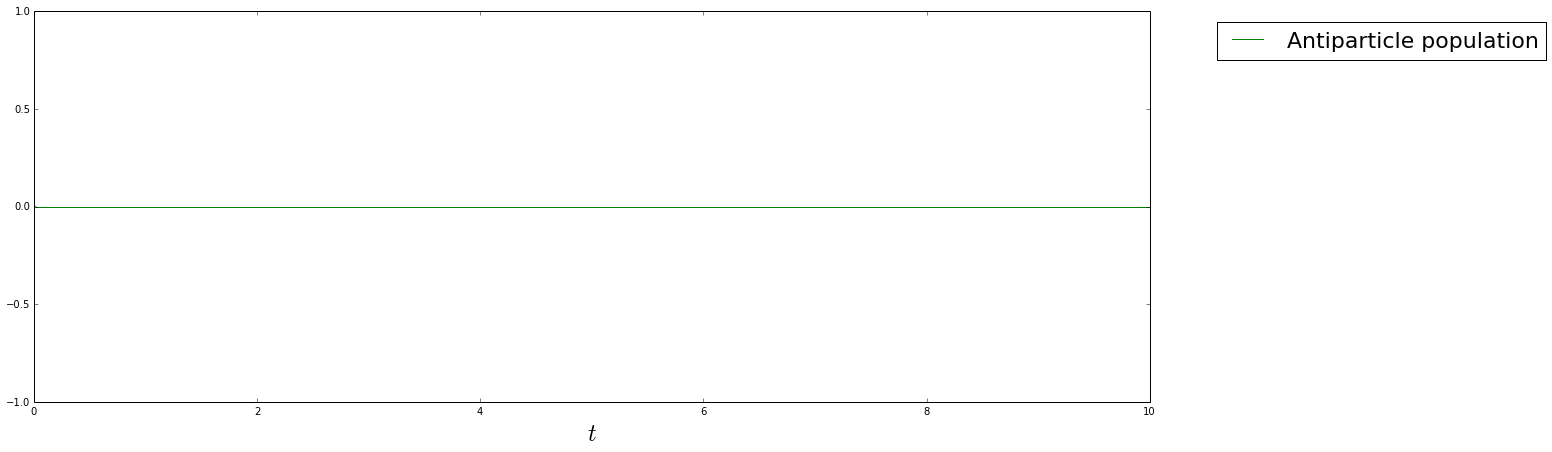

In [22]:
axis_font = {'size':'24'}

fig, ax = plt.subplots(figsize=(20, 7))
ax.plot( instance.timeRange[1:] ,
        instance.antiParticle_population.real  , 'g',
        label= 'Antiparticle population')

ax.set_ylim(-1, 1)

ax.set_xlabel(r'$t$',**axis_font)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})

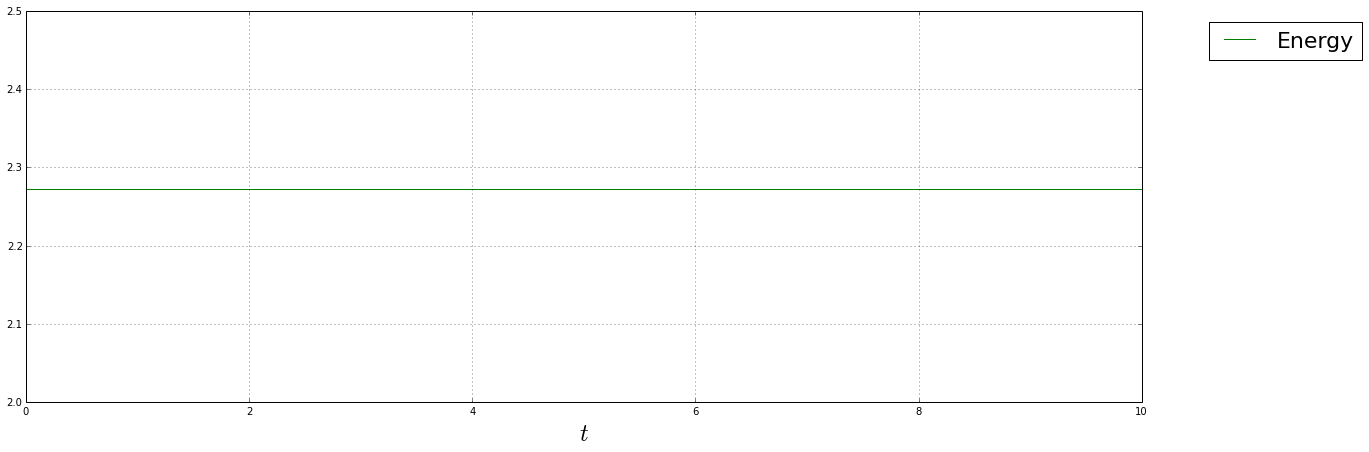

In [28]:
axis_font = {'size':'24'}

fig, ax = plt.subplots(figsize=(20, 7))
ax.plot( instance.timeRange[1:] ,
        instance.Dirac_energy.real  , 'g',
        label= 'Energy')

ax.set_ylim(2, 2.5)
ax.set_xlabel(r'$t$',**axis_font)
ax.grid('on')

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})